In [1106]:
import os
import sys
import pandas as pd
import googletrans
from googletrans import Translator
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans 
import numpy as np
from sklearn.model_selection import GridSearchCV


In [1107]:
# Constants
ROOT_PATH = os.path.abspath(os.getcwd())
CALPI = "calpi"
SETTELMENT = "settelments"
SEED = 170

In [1108]:
def get_data(agg_type, num):
    """returns dataframe of the requested csv
    
    parameters
    ----------
    agg_type - aggregation type of the csv needed
    num - election number
    
    return
    ------
    DataFrame
    """
    if type(num) is not str:
        num = str(num)
    
    
    path = os.path.join(ROOT_PATH,num+agg_type+".xlsx")
    return pd.read_excel(path,dtype=object)

In [1109]:
def remove_small_parties(df,threshold):
    """remove parties that didnt pass the threshold"""
    
    for column in df.columns[7:]:
            if df[column].sum() < threshold:
                   df = df.drop(column,axis=1)
    return df

In [1110]:
def total_voters(df):
    "ploting a barchar from dataframe"
    dict={}
    for c in df.columns[7:]:
        dict[c]=(df[c].sum()/df['valid votes'].sum())*100
    plt.figure(figsize=(20,10))
    plt.bar(range(len(dict)), list(dict.values()), align='center')
    plt.ylabel('Voter turnout')
    plt.xlabel('Parties')
    plt.xticks(range(len(dict)), list(dict.keys()))
    plt.show()

## Plotting voting data

###### plotting data for 23 elections

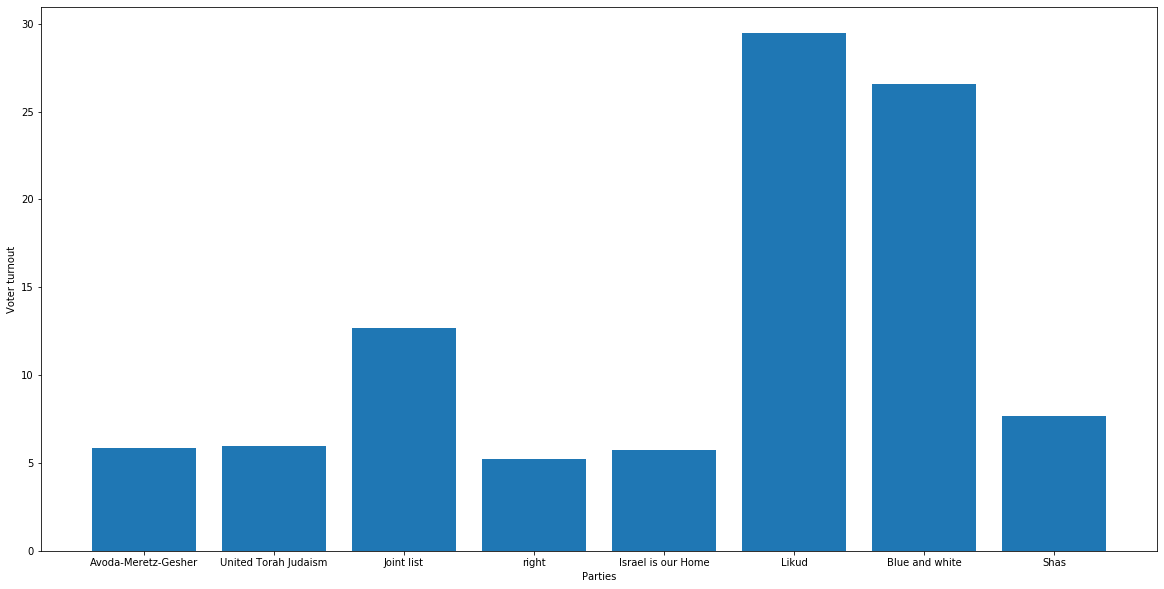

In [1111]:
df_23 = get_data(SETTELMENT,23)
df = remove_small_parties(df_23,135720)
total_voters(df)

###### plotting data for 22 elections

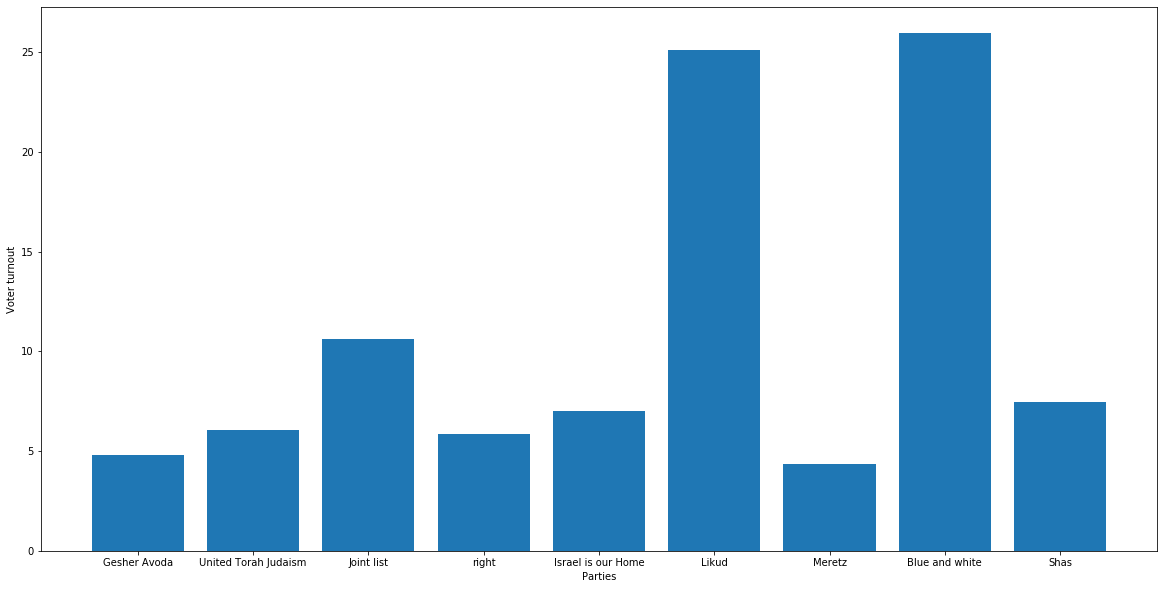

In [1112]:
df_22 = get_data(SETTELMENT,22)
df = remove_small_parties(df_22,135720)
total_voters(df)


###### plotting data for 21 elections

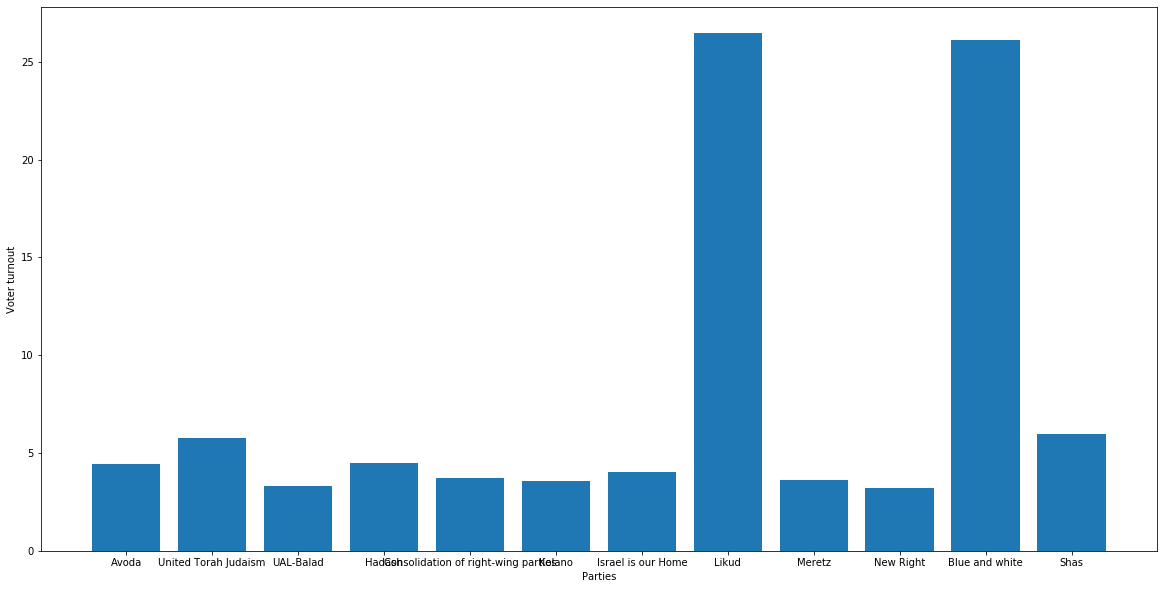

In [1113]:
df_21 = get_data(SETTELMENT,21)
df = remove_small_parties(df_21,135720)
total_voters(df)

In [1114]:
def normalize_to_voting_ratios(df):
    """normalizing the votes according to proportion of votes per party"""
    
    for i,r in df.iterrows():
        for c in df.columns[7:]:
            x = r[c]/r['valid votes']
            df.at[i , c]=x

    return df

In [1115]:
def voting_ratio_process(df):
    """transpose the dataframe
    
    Makes cities as columns and voting proportion as observations.
    Removing extra metadata from dataframe.
    """
    city_names = df["name"].values
    colms_to_remove = df.columns[:7]
    
    
    df = df.drop(labels = colms_to_remove,axis=1)
    return df.values
    
 

In [1116]:
def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

In [1117]:
def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

In [1118]:
def prepare_vectors(df):
    """calculates the distance and the angle if each vector from the base_vector"""
    
    matrix = [] 
    vector_base = np.zeros(df.shape[1])
    vector_base.fill(1)
    print(df.shape)

    for row in df:
        dist = np.linalg.norm(row)
        angle = angle_between(vector_base,row)
        matrix.append([dist,angle])
        
    return np.array(matrix)
    

###### prepare election 21 data

In [1119]:
df_21 = remove_small_parties(df_21,135720)
df_21 = normalize_to_voting_ratios(df_21)
data_21 = voting_ratio_process(df_21)
data_21 = prepare_vectors(data_21)

(1214, 12)


###### prepare election 22 data

In [1120]:
df_22 = remove_small_parties(df_22,135720)
df_22 = normalize_to_voting_ratios(df_22)
data_22 = voting_ratio_process(df_21)
data_22 = prepare_vectors(data_21)

(1214, 2)


In [1121]:
param = {
    "n_clusters":[3,4,5,6,7,8,10,11,12,13],
    "init":["k-means++", "random"],
    "n_init": [10],
    "max_iter":[300],
    "precompute_distances":[False,True],
    "random_state":[SEED],
    "algorithm" : ["auto", "full", "elkan"]

}

gs = GridSearchCV(KMeans(), param,  refit=True, cv=[(slice(None), slice(None))], verbose=1)
gs.fit(vectors)

model = gs.best_estimator_

Fitting 1 folds for each of 120 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:   23.5s finished


In [1122]:
from sklearn.metrics import silhouette_score

y = model.predict(vectors)
silhouette_score(vectors, y, metric='euclidean')

0.39087588175315285

In [1123]:
gs.best_params_

{'algorithm': 'auto',
 'init': 'k-means++',
 'max_iter': 300,
 'n_clusters': 13,
 'n_init': 10,
 'precompute_distances': False,
 'random_state': 170}

Text(0.5, 1.0, 'Incorrect Number of Blobs')

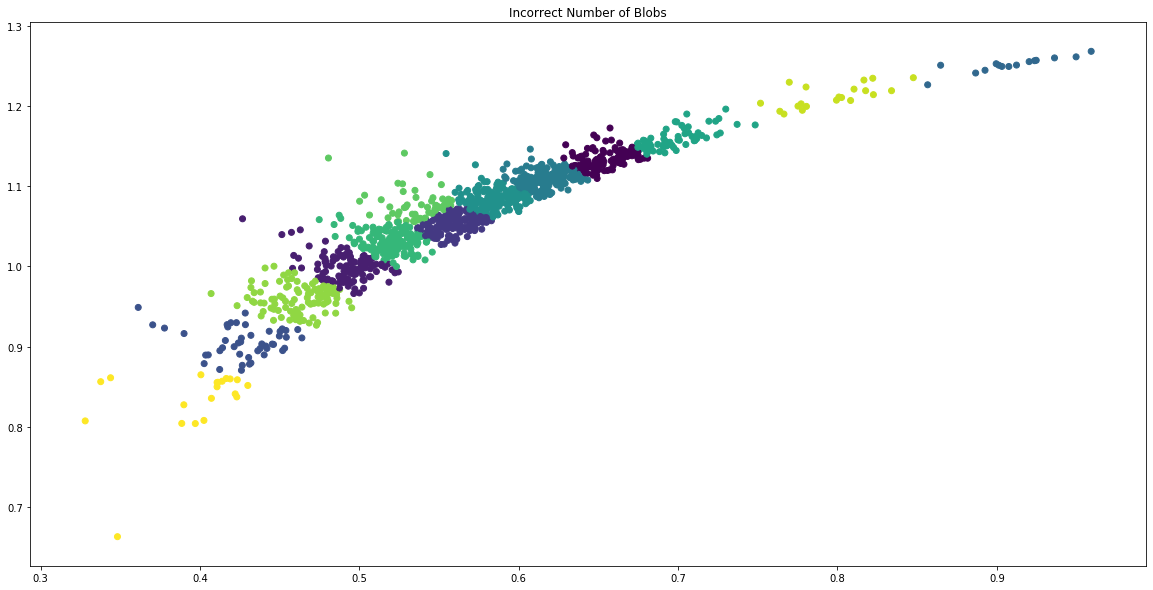

In [1124]:

plt.figure(figsize=(20,10))
plt.scatter(vectors[:,0],vectors[:,1],c=y)
plt.title("Incorrect Number of Blobs")